# Show, Attend and Tell: Neural Image Caption Generation with Visual Attention

[Xu et al. 2015](https://arxiv.org/abs/1502.03044)

In [1]:
from fastai.text import *
import pandas as pd
from pathlib import Path
from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import ImageFile
import pdb
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

In [2]:
gpu = torch.device('cuda:0')

## Download and prepare data
Download the files `Train_GCC-training.tsv` and `Validation_GCC-1.1.0-Validation.tsv` from [here](https://ai.google.com/research/ConceptualCaptions). The files contain URL-Image caption pairs. The scripts `download_images.py` and `download_dataset.sh` help you download the images (install GNU parallel).

1. Put the files `Train_GCC-training.tsv` and `Validation_GCC-1.1.0-Validation.tsv` in separate folders and copy the download scripts in both of them.
2. Run `./download_dataset.sh Train_GCC-training.tsv 200` (and same for validation dataset). Here, the 200 depicts the number of pixels for the smaller side of the images. I recommend 200 but feel free to download them in any other size. The train dataset contains more than 3 million images that take quite a long time to download depending on your internet connection and number of CPU cores. The full dataset requires ~300GB of storage but you can download a subset of the dataset and still get very good results. In order to do so, change line 3 in `download_dataset.sh` i.e. to NUM_LINES=500000.

*Alternatively you could download the COCO dataset which provides image-caption pairs as well. The google dataset is more exciting, however, because it contains real world data as opposed to COOCO which is very academic and cured.*

In [3]:
PATH = Path('data/')
PATH.mkdir(exist_ok=True)

VALID_PATH = PATH/"valid"
VALID_PATH.mkdir(exist_ok=True)

TRAIN_PATH= PATH/"train"
TRAIN_PATH.mkdir(exist_ok=True)

The download script creates one dictionary of downloaded image filenames and corresponding captions per CPU core. We need to combine them:

In [4]:
def show_training_pair(PATH, caption_dict, idx):
    fn, caption = caption_dict[idx]
    img = Image.open(PATH/"downloadedPics"/fn)
    plt.imshow(img)
    print(caption)

In [5]:
def load_partial_dicts(PATH):
    combined_dict = dict()
    for fn in PATH.iterdir():
        if str(fn)[-3:] == "pkl":
            combined_dict.update(pickle.load(fn.open('rb')))
    pickle.dump(combined_dict, open(PATH/'caption_dict.pkl', 'wb'))

In [6]:
load_partial_dicts(VALID_PATH)

In [7]:
valid_dict = pickle.load((VALID_PATH/"caption_dict.pkl").open('rb'))

In [8]:
load_partial_dicts(TRAIN_PATH)

In [9]:
train_dict = pickle.load((TRAIN_PATH/"caption_dict.pkl").open('rb'))

**Example from the validation dataset:**

In [16]:
len(valid_dict)

14205

seals lie on a glacier and rest .


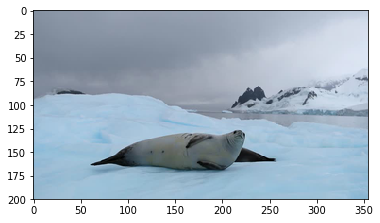

In [11]:
show_training_pair(VALID_PATH, valid_dict, 13900)

**Example from the train dataset:**

In [17]:
len(train_dict)

3035015

football player doubled the lead as she fired past person from the penalty spot before half - time


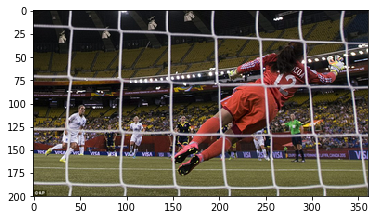

In [20]:
show_training_pair(TRAIN_PATH, train_dict, 131900)

In [22]:
train_dict[12334]

('12334.png', 'riot police detain protester during a may day demonstration .')

#### Let's tokenize the captions and create our vocabulary

In [23]:
tokenizer = Tokenizer()

In [31]:
train_captions_tokenized = tokenizer.process_all(
    list(v[1] for v in train_dict.values())
)

In [44]:
vocab = Vocab.create(train_captions_tokenized, max_vocab=50000, min_freq=2)

In [46]:
pickle.dump(vocab, open(PATH/"vocab.pkl", 'wb'))

In [4]:
vocab = pickle.load((PATH/"vocab.pkl").open('rb'))

In [48]:
def numericalize_tokens(tok):
    return np.array([vocab.numericalize(q) + [1] for q in tok])

The `[1]` stands for the special 'pad token' used here to represent the end of sentence.

In [76]:
def build_data(captions_dict, PATH):
    filenames, captions = zip(*list(captions_dict.values()))
    filenames = list(map(lambda x: str(PATH/"downloadedPics") +"/" + x,filenames))
    captions = tokenizer.process_all(captions)
    captions_tok = numericalize_tokens(captions)
    dataset = (filenames, captions_tok)
    pickle.dump(dataset, open(PATH/"dataset.pkl", 'wb'))

In [77]:
build_data(valid_dict, VALID_PATH)
build_data(train_dict, TRAIN_PATH)

In [9]:
valid_data = pickle.load((VALID_PATH/"dataset.pkl").open('rb'))
train_data = pickle.load((TRAIN_PATH/"dataset.pkl").open('rb'))

In [5]:
valid_data[0][:3]

['data/valid/downloadedPics/5280.png',
 'data/valid/downloadedPics/5281.png',
 'data/valid/downloadedPics/5282.png']

#### Let's create our dataset objects
Custom PyTorch datasets need a `__len__` method returning the length of the dataset and a `__getitem__` method specifying how to access a certain element.

In [5]:
sz = 200

In [6]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
          data (tuple): Contains a list of filenames and a list of tokenized and numericalized captions
          transforms (callable, optional): Optional transforms to be applied
        """
        self.filenames = data[0]
        self.captions  = data[1]
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # Grayscale images in dataset have to be onverted as tensor shapes have to match except in dim=0
        image = Image.open(self.filenames[idx]).convert('RGB')
        caption = self.captions[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption)

In [7]:
tfms = transforms.Compose([
    transforms.Resize(sz),
    #transforms.RandomRotation(10, expand=False),
    transforms.CenterCrop(sz),
    #transforms.RandomCrop(224),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5238, 0.5003, 0.4718], [0.3159, 0.3091, 0.3216])
])

inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)

# To denormalize images
denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

In [10]:
valid_dataset = ImageCaptionDataset(valid_data, transform=tfms)

In [11]:
train_dataset = ImageCaptionDataset(train_data, transform=tfms)

Quick test:

restaurants in the old town on island xxpad


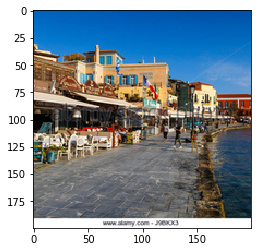

In [12]:
idx = 1084
d = train_dataset
img, cap = d[idx]
print(vocab.textify(cap))
plt.imshow(denorm(img))

#### Let's create our custom DataLoaders

In [13]:
bs = 75

The `pad_collate_ImgCap` function does the following:
A PyTorch DataLoader has the optional argument *collate_fn (callable, optional) – merges a list of samples to form a mini-batch.* Why do we need this? We want to process a large number of images and captions in bulk/at the same time in order to make good use of our GPUs. To do that, both images and captions have to be combined to form two tensors. For the images this is unproblematic, they are simply stacked together. But what happens when the captions don't have the sampe length?

Let's consider the following example:

1. 'dog playing in the grass in summer' -> `[141, 183, 12, 8, 239, 12, 167]`
2. 'cat on sofa' -> `[251, 13, 1035]`

To combine those two captions into a single tensor, we have to *pad* the shorter caption with the special pad token `'xxpad'` or `1`. The resulting tensor then looks like this:
```
tensor([[  251,   141],
        [   13,   183],
        [ 1035,    12],
        [    1,     8],
        [    1,   239],
        [    1,    12],
        [    1,   167],
        [    1,     1]])
```

All captions end with `1` as this also symbolizes *end of sequence* here.

In [14]:
def pad_collate_ImgCap(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False, transpose:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    return (torch.stack(images, 0, out=None), res_cap), res_cap

In [15]:
imgcap_collate_func = partial(pad_collate_ImgCap, pad_first=False, transpose=True)

What do *Samplers* do? 

PyTorch DataLoaders take an optional argument *sampler (Sampler, optional) – defines the strategy to draw samples from the dataset. If specified, shuffle must be False.*

Why do we need this? Take another look at the example caption tensor I showed three cells up. Image having 100 captions of varying length. The length of the tensor will be defined be the longest caption. The shorter captions are padded with 1's. The more padding, the more wasted computations as these tokens contain no information. We want to make sure that the captions that end up in a batch don't contain to much padding. The `SortSampler` returns the indices in a way that the captions are sorted with respect to length (hence the `key=...`). This reduces the need for padding and is perfectly fine for validation as no learning happens. During training, we want a little more randomness as simply feeding the network the captions in sorted order with respect to length is a strong constraint. The `SortishSampler` returns indices for a batch of approximately equally long captions, then indices for a batch of approximately equally short captions, and so on.

In [16]:
val_sampler = SortSampler(valid_data[1], key=lambda x: len(valid_data[1][x]))
trn_sampler = SortishSampler(train_data[1], key=lambda x: len(train_data[1][x]), bs=bs)

In [17]:
val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func)

Quick test:

In [19]:
ims, caps = next(iter(val_dl))

In [20]:
print(ims[0].shape, ims[1].shape, caps.shape)

torch.Size([75, 3, 200, 200]) torch.Size([44, 75]) torch.Size([44, 75])


a protester gives a thumbs - up after he got to the podium and handed a paper with xxunk written on it to politician as she was delivering her speech xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad


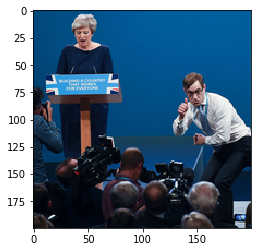

In [21]:
idx = 50
print(vocab.textify(caps[:,idx]))
plt.imshow(denorm(ims[0][idx]))

## Build the architecture

In [18]:
n_hid, n_layers, emb_sz = 400, 3, 300

We want to initialize the embedding with pretrained word vectors (of length 300) from fastText. Download them [here](https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip).

In [22]:
#! pip install git+https://github.com/facebookresearch/fastText.git

In [23]:
import fastText as ft

In [250]:
en_vecs = ft.load_model(str(PATH/'wiki.en.bin'))

In [251]:
vec_dict = {w : en_vecs.get_word_vector(w) for w in en_vecs.get_words()}

In [252]:
pickle.dump(vec_dict, open(PATH/'vec_dict.pkl', 'wb'))

In [19]:
vec_dict = pickle.load(open(PATH/'vec_dict.pkl','rb'))

In [20]:
def create_emb(wordvecs, itos, emb_sz):
    emb= nn.Embedding(len(itos), emb_sz, padding_idx=1)
    weights = emb.weight.data
    not_found = []
    
    for idx, word in enumerate(itos):
        try:
            weights[idx] = torch.from_numpy(wordvecs[word] * 3)
        except:
            not_found.append(word)
    print(len(not_found), not_found[5:10])
    return emb

In [21]:
def MLP(n_in, n_out, p=0.2):
    return nn.Sequential(
        Flatten(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        nn.Linear(in_features=n_in, out_features=n_in, bias=True),
        nn.ReLU(),
        #nn.Linear(in_features=2048, out_features=2048, bias=True),
        #nn.ReLU(),
        #nn.BatchNorm1d(n_in),
        #nn.Dropout(p),
        nn.Linear(in_features=n_in, out_features=n_out, bias=True)
    )

In [22]:
class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            MLP(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
          
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

In [23]:
class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)  # Equation (4) in Xu et al. (2015)
        
    def forward(self, annotation_vecs, dec_hid_state):
        #pdb.set_trace()
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)  # Eq. 4
        alphas = F.softmax(e, dim=1)  # Equation (5) in Xu et al. (2015)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)  # Equations (13)
        
        return context_vec, alphas

In [24]:
class ImageCaptionGenerator(nn.Module):
    def __init__(self, device, filter_width, num_filters, wordvecs, itos, emb_sz, out_seqlen, n_layers=3, prob_teach_forcing=1):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        self.annotation_vecs = None
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, dropout=0.)  # 0.1 square to enable weight tying
        self.out_drop = nn.Dropout(0.)#0.35)
        self.out = nn.Linear(emb_sz, len(itos))
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)  # Section 4.2.1 in Xu et al. (2015)
        
        self.prob_teach_forcing = prob_teach_forcing
       
    def forward(self, x, y=None):
        #pdb.set_trace()
        h, self.annotation_vecs = self.encoder(x.to(self.device))
        pixels_per_channel = self.annotation_vecs.size(1)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            #pdb.set_trace()
            dec_output, h, alpha = self.decode_step(dec_inp, h)
            res.append(dec_output)
            alphas.append(alpha)
            dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
            if (dec_inp == 1).all():
                break
            
            # teacher forcing
            if self.training and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                if i >= len(y):
                    break  # nothing to whisper
                dec_inp = y[i].to(self.device)
                
        return torch.stack(res), torch.stack(alphas)
    
    def decode_step(self, dec_inp, h):
        #pdb.set_trace()
        context_vec, alpha = self.att(self.annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec  # Section 4.2.1 in Xu et al. (2015)
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        return F.log_softmax(output, dim=1), h, alpha

#### Teacher forcing
In the beginning the caption generator will produce only random sentences. We can kick start training by sometimes "whispering the answer for the next word" to the network.

In [34]:
@dataclass
class TeacherForcingCallback(Callback):
    def __init__(self, learn:Learner):
        super().__init__()
        self.learn = learn
        self.batches_per_epoch = len(self.learn.data.train_ds)//self.learn.data.batch_size + 1
    
    def on_batch_begin(self, num_batch: int, epoch: int, **kwargs: Any) -> None:
        self.learn.model.prob_teach_forcing = (self.batches_per_epoch-num_batch) * 1/self.batches_per_epoch if epoch == 0 else 0

#### Loss function

In [35]:
def ImageCaptionLoss(pred, target, lamb = 1):
    pred, alphas = pred
    seqlen, bs = target.size()
    seqlen_pred, bs_pred, n_probs = pred.size()
    
    # we need to pad if target seqlen is larger than prediction seqlen
    if seqlen > seqlen_pred:
        pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))
    
    # but we only compare until the seqlen of the target
    pred = pred[:seqlen]
    
    # cross_entropy can't handle rank 3 tensors currently, we need to flatten
    loss = F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))
    
    # See section 4.2.1 "Doubly stocastic attention"
    penalty = ((1. - alphas.sum(0)) ** 2.).mean()
    # ((1. - alphas.sum(0)) ** 2.).sum(1).mean()

    return loss + lamb * penalty

In [27]:
imgCapGen = ImageCaptionGenerator(gpu, 14, 2048, vec_dict, vocab.itos, emb_sz, 30, n_layers)

3374 ['xxup', 'xxrep', 'xxwrep', ':', "'s"]


In [28]:
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [34]:
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl, device=gpu, path=PATH, collate_fn=imgcap_collate_func)

In [30]:
learn = Learner(data=dataBunch, model=to_device(imgCapGen, gpu), opt_func=opt_fn, loss_func=ImageCaptionLoss, callback_fns=[ShowGraph, TeacherForcingCallback]) # , BnFreeze 

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


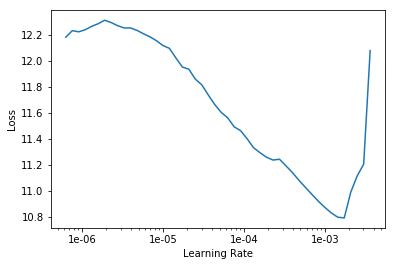

In [36]:
learn.recorder.plot(skip_end=4)

In [32]:
lr = 4e-4

epoch,train_loss,valid_loss,time
0,7.427855,16.907858,04:02
1,6.515100,11.116611,04:44


0 0 1.0
0 1 0.9947368421052631
0 2 0.9894736842105263
0 3 0.9842105263157894
0 4 0.9789473684210527
0 5 0.9736842105263158
0 6 0.968421052631579
0 7 0.9631578947368421
0 8 0.9578947368421052
0 9 0.9526315789473684
0 10 0.9473684210526315
0 11 0.9421052631578948
0 12 0.9368421052631579
0 13 0.9315789473684211
0 14 0.9263157894736842
0 15 0.9210526315789473
0 16 0.9157894736842105
0 17 0.9105263157894737
0 18 0.9052631578947369
0 19 0.9
0 20 0.8947368421052632
0 21 0.8894736842105263
0 22 0.8842105263157894
0 23 0.8789473684210526
0 24 0.8736842105263158
0 25 0.868421052631579
0 26 0.8631578947368421
0 27 0.8578947368421053
0 28 0.8526315789473684
0 29 0.8473684210526315
0 30 0.8421052631578947
0 31 0.8368421052631579
0 32 0.8315789473684211
0 33 0.8263157894736842
0 34 0.8210526315789474
0 35 0.8157894736842105
0 36 0.8105263157894737
0 37 0.8052631578947368
0 38 0.8
0 39 0.7947368421052632
0 40 0.7894736842105263
0 41 0.7842105263157895
0 42 0.7789473684210526
0 43 0.7736842105263158
0

/home/fabiograetz/anaconda3/envs/imgcap/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


0 67 0.6473684210526316
0 68 0.6421052631578947
0 69 0.6368421052631579
0 70 0.631578947368421
0 71 0.6263157894736842
0 72 0.6210526315789474
0 73 0.6157894736842106
0 74 0.6105263157894737
0 75 0.6052631578947368
0 76 0.6
0 77 0.5947368421052631
0 78 0.5894736842105263
0 79 0.5842105263157895
0 80 0.5789473684210527
0 81 0.5736842105263158
0 82 0.5684210526315789
0 83 0.5631578947368421
0 84 0.5578947368421052
0 85 0.5526315789473685
0 86 0.5473684210526316
0 87 0.5421052631578948
0 88 0.5368421052631579
0 89 0.531578947368421
0 90 0.5263157894736842
0 91 0.5210526315789473
0 92 0.5157894736842106
0 93 0.5105263157894737
0 94 0.5052631578947369
0 95 0.5
0 96 0.49473684210526314
0 97 0.48947368421052634
0 98 0.4842105263157895
0 99 0.4789473684210526
0 100 0.47368421052631576
0 101 0.46842105263157896
0 102 0.4631578947368421
0 103 0.45789473684210524
0 104 0.45263157894736844
0 105 0.4473684210526316
0 106 0.4421052631578947
0 107 0.4368421052631579
0 108 0.43157894736842106
0 109 0.

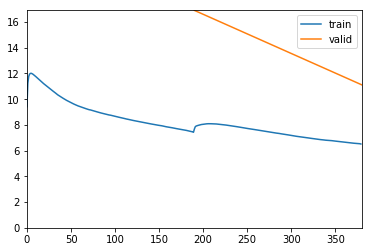

1 0 0
1 1 0
1 2 0
1 3 0
1 4 0
1 5 0
1 6 0
1 7 0
1 8 0
1 9 0
1 10 0
1 11 0
1 12 0
1 13 0
1 14 0
1 15 0
1 16 0
1 17 0
1 18 0
1 19 0
1 20 0
1 21 0
1 22 0
1 23 0
1 24 0
1 25 0
1 26 0
1 27 0
1 28 0
1 29 0
1 30 0
1 31 0
1 32 0
1 33 0
1 34 0
1 35 0
1 36 0
1 37 0
1 38 0
1 39 0
1 40 0
1 41 0
1 42 0
1 43 0
1 44 0
1 45 0
1 46 0
1 47 0
1 48 0
1 49 0
1 50 0
1 51 0
1 52 0
1 53 0
1 54 0
1 55 0
1 56 0
1 57 0
1 58 0
1 59 0
1 60 0
1 61 0
1 62 0
1 63 0
1 64 0
1 65 0
1 66 0
1 67 0
1 68 0
1 69 0
1 70 0
1 71 0
1 72 0
1 73 0
1 74 0
1 75 0
1 76 0
1 77 0
1 78 0
1 79 0
1 80 0
1 81 0
1 82 0
1 83 0
1 84 0
1 85 0
1 86 0
1 87 0
1 88 0
1 89 0
1 90 0
1 91 0
1 92 0
1 93 0
1 94 0
1 95 0
1 96 0
1 97 0
1 98 0
1 99 0
1 100 0
1 101 0
1 102 0
1 103 0
1 104 0
1 105 0
1 106 0
1 107 0
1 108 0
1 109 0
1 110 0
1 111 0
1 112 0
1 113 0
1 114 0
1 115 0
1 116 0
1 117 0
1 118 0
1 119 0
1 120 0
1 121 0
1 122 0
1 123 0
1 124 0
1 125 0
1 126 0
1 127 0
1 128 0
1 129 0
1 130 0
1 131 0
1 132 0
1 133 0
1 134 0
1 135 0
1 136 0
1 137 0
1 138 

In [33]:
learn.fit_one_cycle(2, lr)